In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import LogLocator
import json

# 参数设置

In [1501]:
import matplotlib.font_manager as fm

font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
available_fonts = [fm.FontProperties(fname=fname).get_name() for fname in font_list]
print(available_fonts)

['Liberation Sans', 'Nimbus Mono PS', 'Lato', 'Lato', 'Liberation Sans Narrow', 'MathJax_SansSerif', 'MathJax_Fraktur', 'DejaVu Sans', 'DejaVu Sans Mono', 'Lato', 'Nimbus Roman', 'cmsy10', 'Liberation Mono', 'Lato', 'Liberation Serif', 'MathJax_Math', 'Noto Mono', 'DejaVu Serif', 'Nimbus Sans Narrow', 'P052', 'DejaVu Serif', 'MathJax_Size3', 'Lato', 'wasy10', 'Lato', 'MathJax_SansSerif', 'MathJax_Size1', 'Nimbus Sans', 'Liberation Mono', 'Liberation Sans', 'Bitstream Vera Sans Mono', 'Liberation Sans', 'MathJax_Main', 'Nimbus Mono PS', 'Lato', 'Droid Sans Fallback', 'MathJax_Size2', 'DejaVu Sans', 'Liberation Mono', 'Lato', 'Bitstream Vera Serif', 'stmary10', 'MathJax_WinChrome', 'URW Bookman', 'Lato', 'DejaVu Sans', 'Liberation Serif', 'DejaVu Serif', 'Nimbus Roman', 'Bitstream Vera Sans', 'MathJax_Math', 'Bitstream Vera Sans Mono', 'DejaVu Serif', 'Nimbus Sans Narrow', 'Nimbus Mono PS', 'MathJax_Typewriter', 'DejaVu Serif', 'Lato', 'Bitstream Vera Sans', 'Nimbus Sans', 'Nimbus Sans N

In [1525]:
mpl.rcParams.update(mpl.rcParamsDefault)

In [1523]:
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Computer Modern'] + plt.rcParams['font.serif']

In [1502]:
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['cmr10', 'Computer Modern Roman', 'DejaVu Serif']
# plt.rcParams['mathtext.fontset'] = 'cm'

In [1511]:
# plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['font.family'] = 'STIXGeneral'

In [4]:
# 设置matplotlib使用math text
plt.rcParams['axes.formatter.use_mathtext'] = True
# 如果需要更完整的数学字体设置，可以添加：
plt.rcParams['mathtext.fontset'] = 'cm'  # 使用Computer Modern字体
plt.rcParams['font.family'] = 'STIXGeneral'  # 使用STIX字体族

In [27]:
# 更详细的设置方式
sns.set(
    style="whitegrid",
    context="paper",
    font="STIXGeneral",
    font_scale=1.5,
    rc={
        'axes.formatter.use_mathtext': True,
        'mathtext.fontset': 'cm',
        'font.family': 'STIXGeneral'
    }
)

In [5]:
# 合约中的函数和论文中的phase之间的映射关系
phase_dic = {
    'deploy': 'P1: Setup',
    'mintDataNFT': 'P2: Mint data NFT',
    'requestDataPurchase': 'P3: Request data',
    'confirmRequest': 'P3: Request data',
    'buyerDeposit': 'P3: Request data',
    'ownerDeposit': 'P3: Request data',
    'initiateChallenge': 'P4: Challenge',
    'ownerResToChallenge': 'P4: Challenge',
    'buyerVerifyChallenge': 'P4: Challenge',
    'otherOwnersResToChallenge': 'P4: Challenge',
    'buyerConfirmChallengeEnd': 'P4: Challenge',
    'setHashchainTip': 'P5: Batch payment',
    'confirmFinalPayment': 'P5: Batch payment'
}

In [67]:
# palette = ['#FFD700', '#98FB98', '#FFA07A', '#87CEFA', '#DDA0DD']
# palette = ['#FFC300', '#98FB98', '#FFA07A', '#ADD8E6', '#DDA0DD']
palette = ['#FFC300', '#32CD32', '#FFA07A', '#87CEFA', '#BA55D3']
# palette = sns.color_palette("deep", 5)

In [7]:
# network = 'localhost'
network = 'sepolia'

# Performance

## 初始化

In [68]:
df_p = pd.read_csv(f'results/{network}_performance.csv', quotechar='"', escapechar='\\')
df_p = df_p[df_p[df_p.method=='deploy'].index[-1]-9:].reset_index(drop=1)
columns_p = ['method','latency','gas']
df_p = df_p[columns_p]
df_p['phase'] = df_p.method.map(phase_dic)
df_p['experiment_id'] = (df_p['phase'].str.contains('P2')).cumsum()
df_p.loc[df_p.index[:10], 'experiment_id'] = range(1, 11)

phase_sums_p = df_p.groupby(['experiment_id', 'phase']).agg({
    'latency': 'sum',
    'gas': 'sum'
}).reset_index()
# 将latency转换为分钟
phase_sums_p.latency = phase_sums_p.latency / 1000 / 60 

In [69]:
df_p = pd.read_csv(f'results/{network}_performance.csv', quotechar='"', escapechar='\\')
df_p = df_p[df_p[df_p.method=='deploy'].index[-1]-9:].reset_index(drop=1)
columns_p = ['method','latency','gas']
df_p = df_p[columns_p]
df_p['phase'] = df_p.method.map(phase_dic)
df_p['experiment_id'] = (df_p['phase'].str.contains('P2')).cumsum()

In [70]:
for i in range(1,6):
    ret = phase_sums_p[phase_sums_p.phase.str.contains('P'+str(i))].gas.unique()
    print(f'P{i}: {ret}')

P1: [4421929]
P2: [232532 198332 198356]
P3: [349072]
P4: [419908 419488 419830 419914 419422 419951 419397 419361 419410 419878]
P5: [179242 179230]


In [71]:
for i in range(1,6):
    ret = phase_sums_p[phase_sums_p.phase.str.contains('P'+str(i))].latency.unique()
    print(f'P{i}: {ret}')

P1: [0.15546667 0.22971667 0.14298333 0.16595    0.15443333 0.3479
 0.14826667 0.15661667 0.38618333 0.12866667]
P2: [0.35366667 0.1885     0.20661667 0.19695    0.20138333 0.20231667
 0.29096667 0.20061667 0.1847     0.40486667]
P3: [1.46066667 0.8084     0.7934     0.81196667 1.01868333 0.99286667
 0.9946     1.19793333 0.81006667 1.21928333]
P4: [0.9348     0.78661667 0.80675    0.97701667 1.00566667 1.19681667
 1.38923333 0.8281     0.78713333 0.99991667]
P5: [0.59541667 0.83421667 0.39653333 0.60393333 0.39131667 0.6081
 0.40075    0.38178333 0.39553333 0.38631667]


## 各个Phase性能分布

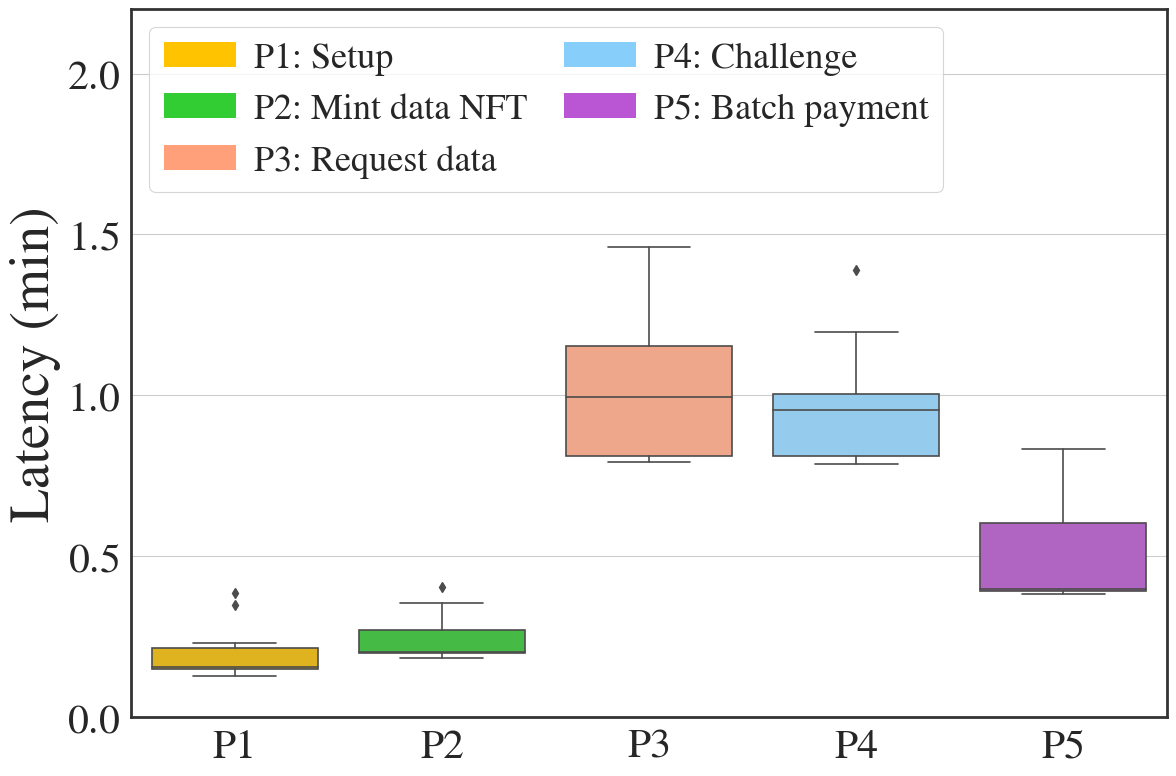

In [72]:
# 创建一个图形对象
fig, ax = plt.subplots(figsize=(12, 8))

# 定义颜色映射
color_map = dict(zip(phase_sums_p['phase'].unique(), palette))

# Latency箱线图
sns.boxplot(x='phase', y='latency', data=phase_sums_p, ax=ax, palette=color_map)

ax.set_xlabel('')
ax.set_ylabel('Latency (min)', fontsize=40)

# 设置 x 轴标签
x_labels = ['P1', 'P2', 'P3', 'P4', 'P5']
ax.set_xticklabels(x_labels)

# 增加 x 轴和 y 轴标签的字体大小
ax.tick_params(axis='both', labelsize=30)

# 加粗边框
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('#333333')
    spine.set_linewidth(2)

# 创建图例
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, edgecolor='none') for color in color_map.values()]
ax.legend(legend_elements, color_map.keys(), 
          title='', 
          loc='upper left', 
          fontsize=26, 
          title_fontsize=18,
          ncol=2,  # 设置为两列
          columnspacing=1,  # 调整列间距
          handletextpad=0.5)  # 调整图例符号和文本之间的间距

# 调整y轴范围
plt.ylim(0, 2.2)

# 调整布局
plt.tight_layout()

# 保存图片
plt.savefig(f'./figs/{network}/latency distribution.pdf', dpi=300, bbox_inches='tight')

# 显示图表
plt.show()

## 各个Phase性能占比

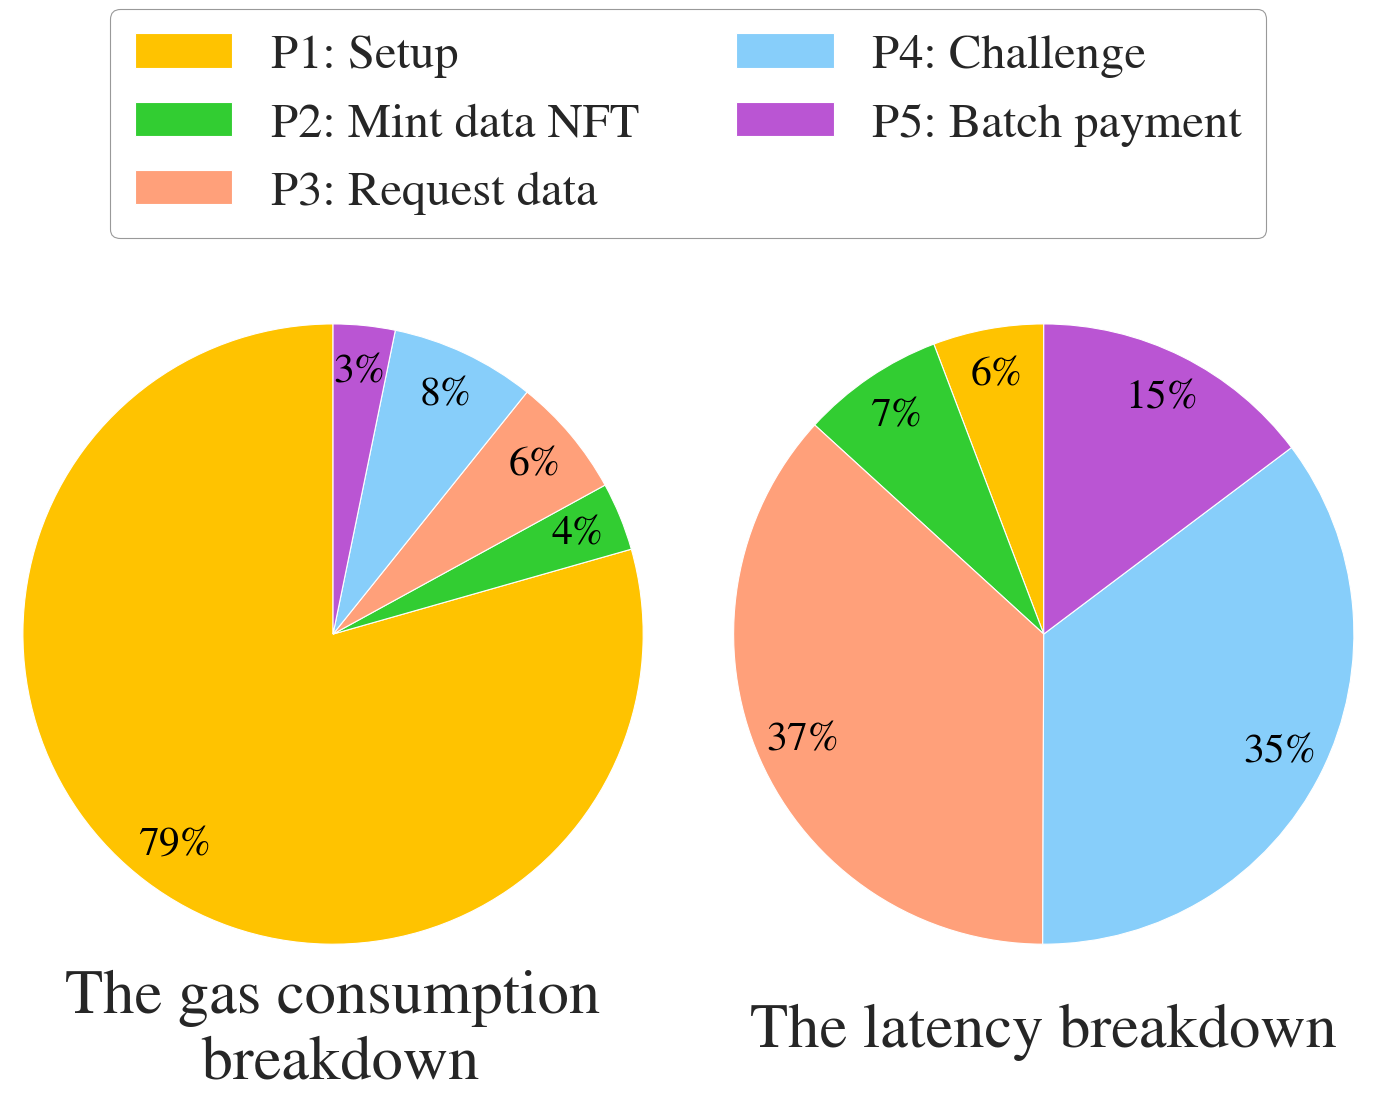

In [73]:
# 计算每个 phase 的中位数
phase_median_p = phase_sums_p.groupby('phase').median().reset_index()

# 设置适中的颜色和标签
labels = phase_median_p['phase']

# 创建更大的图形和子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 12))  # 增加图形大小

# 定义一个函数来格式化百分比，去掉小数点
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.0f}%'
    return my_autopct

# Gas 消耗饼图
wedges1, texts1, autotexts1 = ax1.pie(phase_median_p['gas'], colors=palette, 
                                      autopct=make_autopct(phase_median_p['gas']), 
                                      startangle=90, pctdistance=0.85,
                                      radius=1.2)  # 增加饼图半径
ax1.set_title('The gas consumption\n breakdown', y=-0.2, fontsize=45)

# Latency 饼图
wedges2, texts2, autotexts2 = ax2.pie(phase_median_p['latency'], colors=palette, 
                                      autopct=make_autopct(phase_median_p['latency']), 
                                      startangle=90, pctdistance=0.85,
                                      radius=1.2)  # 增加饼图半径
ax2.set_title('The latency breakdown', y=-0.15, fontsize=45)

# 计算每行应显示的标签数量
labels_per_row = (len(labels) + 1) // 2  # 使用整除，确保均匀分布

# 在图形顶部中间添加图例，分两行显示
fig.legend(wedges1, labels, title="", loc="upper center", 
           bbox_to_anchor=(0.5, 1.1),  # 调整垂直位置，为两行图例留出空间
           ncol=labels_per_row-1,  # 设置每行的列数
           fontsize=35,
           borderpad=0.5,  # 设置外边框的厚度
           frameon=True,  # 显示边框
           edgecolor='grey',  # 设置边框颜色
           facecolor='white',  # 设置填充颜色
)
# 设置百分比标签的颜色为黑色并增大字体
for autotext in autotexts1 + autotexts2:
    autotext.set_color('black')
    autotext.set_fontsize(30)  # 增大字体

# 调整布局
plt.tight_layout()
plt.subplots_adjust(top=1.1, wspace=0.1)  # 减少子图之间的间距

# 保存图片到本地
plt.savefig(f'./figs/{network}/performance breakdown.pdf', dpi=300, bbox_inches='tight')

# 显示图表
plt.show()

# Batch Number

## 初始化

In [74]:
df_b = pd.read_csv(f'results/{network}_batch_number.csv', quotechar='"', escapechar='\\')
df_b = df_b[df_b[df_b.method=='deploy'].index[-1]-9:].reset_index(drop=1)
columns_b = ['method','batchNumber','latency','gas']
df_b = df_b[columns_b]
df_b['phase'] = df_b.method.map(phase_dic)
df_b.loc[df_b.index[:10], 'batchNumber'] = range(100, 1001, 100)

phase_sums_b = df_b.groupby(['batchNumber', 'phase']).agg({
    'latency': 'sum',
    'gas': 'sum'
}).reset_index()

# 将latency转换为分钟
phase_sums_b.latency = phase_sums_b.latency / 1000 / 60 

In [75]:
gases = phase_sums_b[phase_sums_b.phase.str.contains('P5')].gas

## 各个Phase的Gas

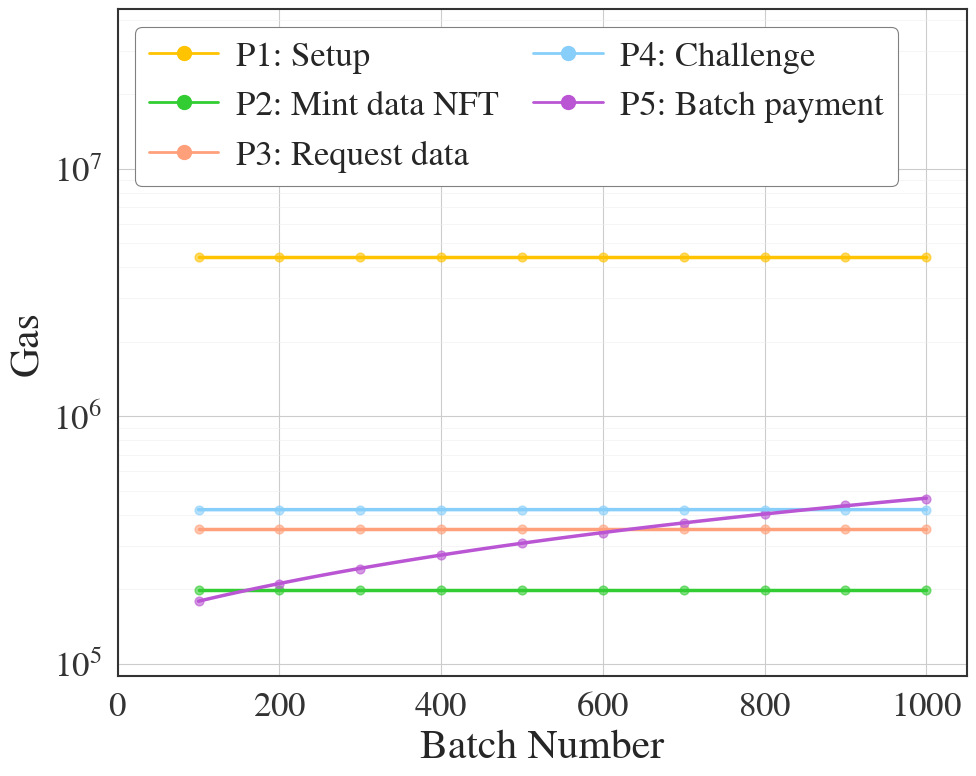

In [98]:
g = sns.lmplot(
    data=phase_sums_b, 
    x='batchNumber', 
    y='gas', 
    hue='phase',
    height=8,
    aspect=10/8,
    scatter_kws={'alpha': 0.6, 's': 40},
    line_kws={'linewidth': 2.5},
    palette=palette,
    legend=False,
    facet_kws={'legend_out': False},
    ci=68,
    order=1
)

# 获取当前的颜色映射
color_map = dict(zip(phase_sums_b['phase'].unique(), palette))

# 创建自定义图例元素
legend_elements = [
    Line2D([0], [0], marker='o', color=color, markerfacecolor=color, markersize=10, 
           linestyle='-', linewidth=2, label=phase)
    for phase, color in color_map.items()
]

# 添加自定义图例
g.ax.legend(handles=legend_elements, 
            loc='upper left', 
            fontsize=25, 
            title='',
            ncol=2,  # 设置为两列
            columnspacing=1,  # 调整列间距
            handletextpad=0.5,  # 调整图例符号和文本之间的间距
            frameon=True, edgecolor='grey', framealpha=1.0)

g.ax.set_yscale('log')
g.set_axis_labels('Batch Number', 'Gas', fontsize=30)
g.ax.set_ylim(phase_sums_b['gas'].min() * 0.5, phase_sums_b['gas'].max() * 10)
g.ax.set_xlim(0, phase_sums_b['batchNumber'].max() * 1.05)

g.ax.grid(which='major', linewidth=0.8, color='#CCCCCC')
g.ax.grid(which='minor', linewidth=0.4, color='#EEEEEE')
g.ax.tick_params(axis='both', which='major', labelsize=25, colors='#333333', length=8, width=1)
g.ax.tick_params(axis='both', which='minor', labelsize=25, colors='#333333', length=4, width=1)

for spine in g.ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('#333333')
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig(f'./figs/{network}/gas vs batchNumber.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 各个Phase的Latency

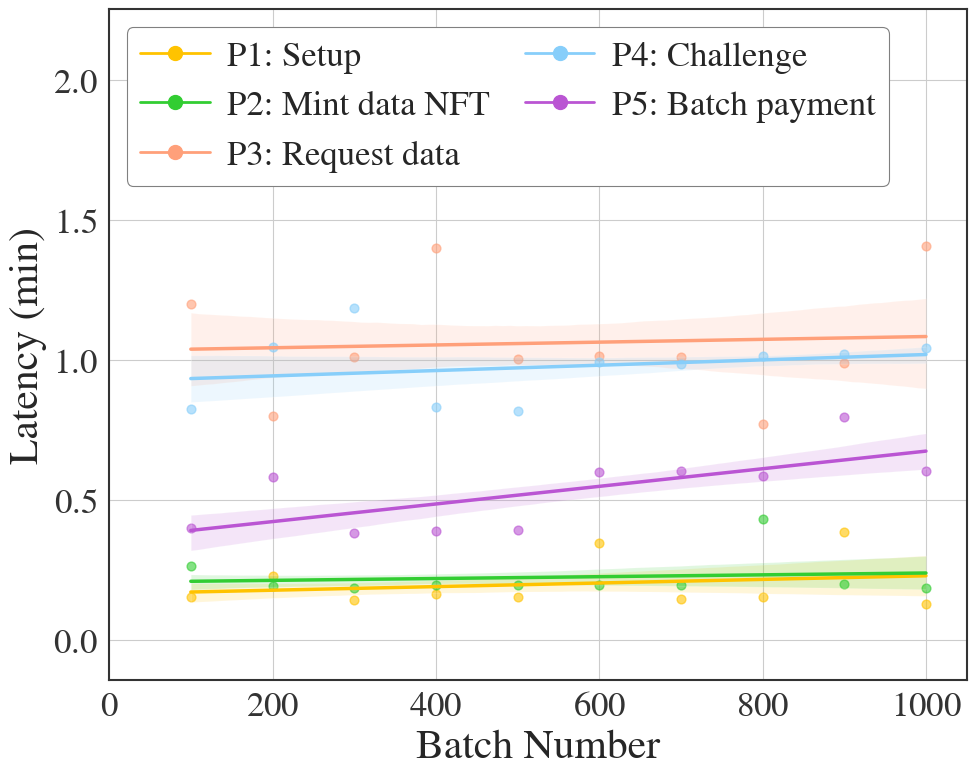

In [99]:
g = sns.lmplot(
    data=phase_sums_b, 
    x='batchNumber', 
    y='latency', 
    hue='phase',
    height=8,
    aspect=10/8,
    scatter_kws={'alpha': 0.6, 's': 40},
    line_kws={'linewidth': 2.5},
    palette=palette,
    legend=False,
    facet_kws={'legend_out': False},
    ci=68,
    order=1
)

# 获取当前的颜色映射
color_map = dict(zip(phase_sums_b['phase'].unique(), palette))

# 创建自定义图例元素
legend_elements = [
    Line2D([0], [0], marker='o', color=color, markerfacecolor=color, markersize=10, 
           linestyle='-', linewidth=2, label=phase)
    for phase, color in color_map.items()
]

# 添加自定义图例
g.ax.legend(handles=legend_elements, 
            loc='upper left', 
            fontsize=25, 
            title='',
            ncol=2,  # 设置为两列
            columnspacing=1,  # 调整列间距
            handletextpad=0.5,  # 调整图例符号和文本之间的间距
            frameon=True, edgecolor='grey', framealpha=1.0)

g.set_axis_labels('Batch Number', 'Latency (min)', fontsize=30)
# 设置 y 轴刻度为 0.5 的倍数
g.ax.yaxis.set_major_locator(MultipleLocator(0.5))
g.ax.set_ylim(phase_sums_b['latency'].min() * -1.1, phase_sums_b['latency'].max() * 1.6)
g.ax.set_xlim(0, phase_sums_b['batchNumber'].max() * 1.05)

# 其他设置保持不变
g.ax.grid(which='major', linewidth=0.8, color='#CCCCCC')
g.ax.grid(which='minor', linewidth=0.4, color='#EEEEEE')
g.ax.tick_params(axis='both', which='major', labelsize=25, colors='#333333')

for spine in g.ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('#333333')
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig(f'./figs/{network}/latency vs batchNumber.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Challenge Size

## 初始化

In [78]:
df_c = pd.read_csv(f'results/{network}_challenge_size.csv', quotechar='"', escapechar='\\')
df_c = df_c[df_c[df_c.method=='deploy'].index[-1]-9:].reset_index(drop=1)
columns_c = ['method','challengeSize','latency','gas']
df_c = df_c[columns_c]
df_c['phase'] = df_c.method.map(phase_dic)
df_c.loc[df_c.index[:10], 'challengeSize'] = range(10, 101, 10)

phase_sums_c = df_c.groupby(['challengeSize', 'phase']).agg({
    'latency': 'sum',
    'gas': 'sum'
}).reset_index()

# 将latency转换为分钟
phase_sums_c.latency = phase_sums_c.latency / 1000 / 60

In [79]:
gases = phase_sums_c[phase_sums_c.phase.str.contains('P4')].gas

In [80]:
gases.max() / gases.min()

4.588518569679764

## 各个Phase的Gas

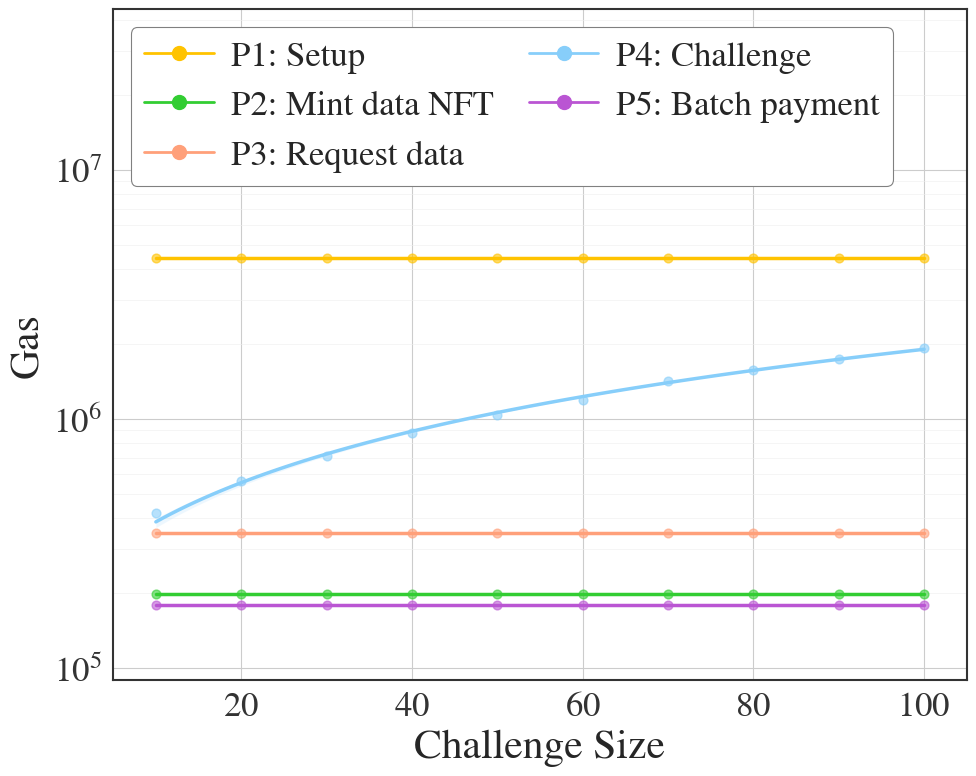

In [100]:
g = sns.lmplot(
    data=phase_sums_c, 
    x='challengeSize', 
    y='gas', 
    hue='phase',
    height=8,
    aspect=10/8,
    scatter_kws={'alpha': 0.6, 's': 40},
    line_kws={'linewidth': 2.5},
    palette=palette,
    legend=False,
    facet_kws={'legend_out': False},
    ci=68,
    order=1
)

# 获取当前的颜色映射
color_map = dict(zip(phase_sums_c['phase'].unique(), palette))

# 创建自定义图例元素
legend_elements = [
    Line2D([0], [0], marker='o', color=color, markerfacecolor=color, markersize=10, 
           linestyle='-', linewidth=2, label=phase)
    for phase, color in color_map.items()
]

# 添加自定义图例
g.ax.legend(handles=legend_elements, 
            loc='upper left', 
            fontsize=25, 
            title='',
            ncol=2,  # 设置为两列
            columnspacing=1,  # 调整列间距
            handletextpad=0.5,  # 调整图例符号和文本之间的间距
            frameon=True, edgecolor='grey', framealpha=1.0)

g.ax.set_yscale('log')
g.set_axis_labels('Challenge Size', 'Gas', fontsize=30)
g.ax.set_ylim(phase_sums_c['gas'].min() * 0.5, phase_sums_c['gas'].max() * 10)
g.ax.set_xlim(phase_sums_c['challengeSize'].min() - 5, phase_sums_c['challengeSize'].max() + 5)

g.ax.grid(which='major', linewidth=0.8, color='#CCCCCC')
g.ax.grid(which='minor', linewidth=0.4, color='#EEEEEE')
g.ax.tick_params(axis='both', which='major', labelsize=25, colors='#333333')

for spine in g.ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('#333333')
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig(f'./figs/{network}/gas vs challengeSize.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 各个Phase的Latency

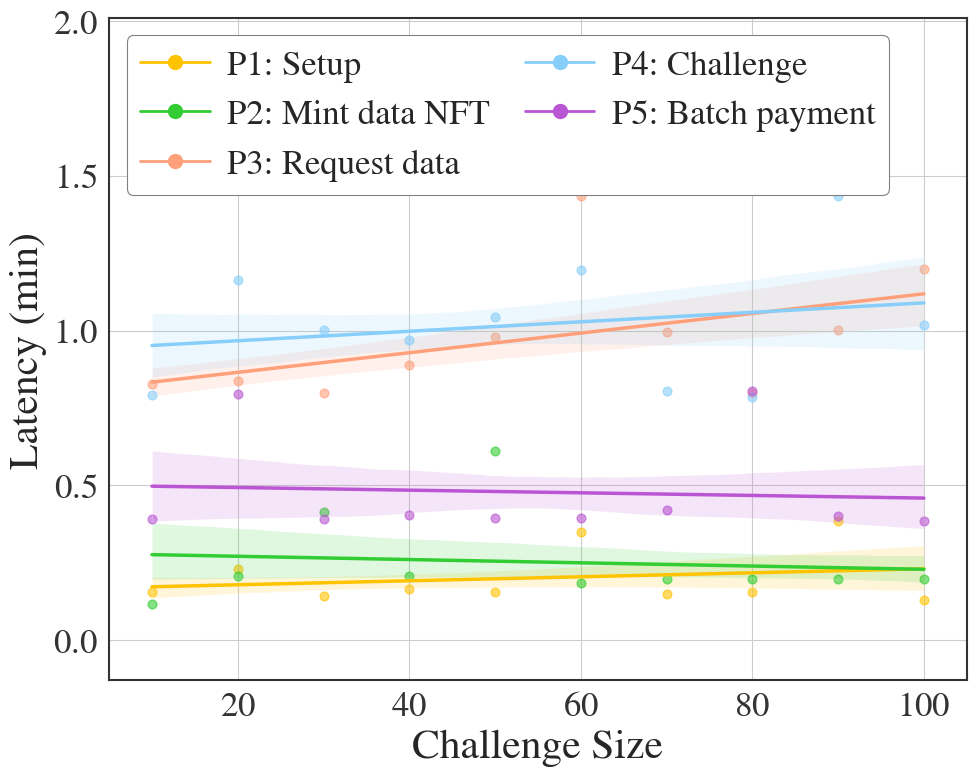

In [101]:
g = sns.lmplot(
    data=phase_sums_c, 
    x='challengeSize', 
    y='latency', 
    hue='phase',
    height=8,
    aspect=10/8,
    scatter_kws={'alpha': 0.6, 's': 40},
    line_kws={'linewidth': 2.5},
    palette=palette,
    legend=False,
    facet_kws={'legend_out': False},
    ci=68,
    order=1
)

# 获取当前的颜色映射
color_map = dict(zip(phase_sums_c['phase'].unique(), palette))

# 创建自定义图例元素
legend_elements = [
    Line2D([0], [0], marker='o', color=color, markerfacecolor=color, markersize=10, 
           linestyle='-', linewidth=2, label=phase)
    for phase, color in color_map.items()
]

# 添加自定义图例
g.ax.legend(handles=legend_elements, 
            loc='upper left', 
            fontsize=25, 
            title='',
            ncol=2,  # 设置为两列
            columnspacing=1,  # 调整列间距
            handletextpad=0.5,  # 调整图例符号和文本之间的间距
            frameon=True, edgecolor='grey', framealpha=1.0)

g.set_axis_labels('Challenge Size', 'Latency (min)', fontsize=30)
# 设置 y 轴刻度为 0.5 的倍数
g.ax.yaxis.set_major_locator(MultipleLocator(0.5))
g.ax.set_ylim(phase_sums_c['latency'].min() * -1.1, phase_sums_c['latency'].max() * 1.4)
g.ax.set_xlim(phase_sums_c['challengeSize'].min() - 5, phase_sums_c['challengeSize'].max() + 5)

g.ax.grid(which='major', linewidth=0.8, color='#CCCCCC')
g.ax.grid(which='minor', linewidth=0.4, color='#EEEEEE')
g.ax.tick_params(axis='both', which='major', labelsize=25, colors='#333333')

for spine in g.ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('#333333')
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig(f'./figs/{network}/latency vs challengeSize.pdf', dpi=300, bbox_inches='tight')
plt.show()